In [1]:
import json
from tqdm import tqdm
import uuid
import os
from transformers import AutoProcessor, Kosmos2ForConditionalGeneration
import math
import imgviz
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
from collections import defaultdict
from get_data_from_XML import XML_preprocessor
import json
from PIL import Image
import glob
from transformers import AutoProcessor

/home/omote/cluster_project/iam2/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_json(file_path):
    with open(file_path, "r") as f:
        data = json.load(f)
    return data

def save_json(data, file_path):
    """
    Save a Python dictionary to a JSON file.

    Parameters:
        data (dict): The data to save.
        file_path (str): The path where the JSON file will be saved.
    """
    with open(file_path, 'w', encoding='utf-8') as file:
        json.dump(data, file, ensure_ascii=False, indent=4)
        
def bbox_absolute_to_relative(absolute_bbox, image_width_height):
    width, height = image_width_height
    x1 = absolute_bbox[0] / width
    y1 = absolute_bbox[1] / height
    x2 = absolute_bbox[2] / width
    y2 = absolute_bbox[3] / height
    relative_bbox = [x1, y1, x2, y2]
    return relative_bbox

def bbox_relative_to_absolute(relative_bbox, image_width_height):
    width, height = image_width_height
    x1 = relative_bbox[0] * width
    y1 = relative_bbox[1] * height
    x2 = relative_bbox[2] * width
    y2 = relative_bbox[3] * height
    absolute_bbox = [x1, y1, x2, y2]
    return absolute_bbox

def visualize_bbox(image, bbox_list, bbox_name_list,bbox_is_relative=True,with_id=False):
    assert len(bbox_list) == len(bbox_name_list), "bbox_list and bbox_name_list must have the same length"
    if isinstance(image, str):
        image = Image.open(image).convert("RGB")

    if bbox_is_relative:
        # 画像のサイズを取得
        image_width_height = (image.width, image.height)
        # 相対座標を絶対座標に変換
        bbox_list = [bbox_relative_to_absolute(bbox, image_width_height) for bbox in bbox_list]
        
    #bbox_name_listをソート、bbox_listも同じ順番にソート
    # bbox_name_list, bbox_list = zip(*sorted(zip(bbox_name_list, bbox_list), key=lambda x: x[0]))
    # bbox_name_list = list(bbox_name_list)
    # bbox_list = list(bbox_list)
    name_to_label_id_dict = {}
    label_id = 0
    for bbox_name in bbox_name_list:
        if bbox_name not in name_to_label_id_dict:
            name_to_label_id_dict[bbox_name] = label_id
            label_id += 1    
    
    # bbox_listの座標をy1, x1, y2, x2の形式に変換
    bboxes = []
    labels = []
    # label_id = -1
    # old_label = None
    count_object_dict = {}
    id_bbox_name_list = []
    for bbox ,bbox_name in zip(bbox_list, bbox_name_list):
        x1, y1, x2, y2 = bbox
        bboxes.append([y1, x1, y2, x2])
        # if old_label != bbox_name:
        #     label_id += 1
        #     old_label = bbox_name
        label_id = name_to_label_id_dict[bbox_name]
        if bbox_name not in count_object_dict:
            count_object_dict[bbox_name] = 0
        else:
            count_object_dict[bbox_name] += 1
        if with_id:
            bbox_name = f"{bbox_name}_{count_object_dict[bbox_name]}"
            id_bbox_name_list.append(bbox_name)
        labels.append(label_id)
    # bboxes = np.array([bbox[1],bbox[0],bbox[3],bbox[2]]).astype(np.int32).reshape(-1, 4)
    
    base_resolution = 100 * 100
    base_font_size = 3
    image_resolution = image.width * image.height
    font_size = int( base_font_size * (image_resolution / base_resolution) ** 0.5)
    
    if with_id:
        bbox_name_list = id_bbox_name_list
    image = imgviz.instances2rgb(np.array(image), bboxes=bboxes, labels=labels,font_size=font_size,captions=bbox_name_list)

    plt.imshow(image)
    plt.show()

In [ ]:
def load_txt(file_path):
    with open(file_path, "r") as f:
        lines = f.readlines()
    return [line.strip() for line in lines]

def load_anno(anno_folder,image_folder_root):
    anno_label_path_list = glob.glob(os.path.join(anno_folder, "*.txt"))
    anno_label_list = [load_txt(path) for path in anno_label_path_list]
    anno_id_list = [os.path.splitext(os.path.basename(path))[0] for path in anno_label_path_list]
    image_path_list = [os.path.join(f"PASCAL-VOC/ultralytics/images/", os.path.basename(anno_folder), f"{anno_id}.jpg") for anno_id in anno_id_list]

    for image_path in image_path_list:
        image_path = os.path.join(image_folder_root, image_path)
        if not os.path.exists(image_path):
            print(f"Image not found: {image_path}")
            
    return anno_id_list, anno_label_list, image_path_list

def anno_label_list_to_bbox_list(anno_label_list, cat_id2name):
    bbox_list_list = []
    bbox_bame_list_list = []
    for anno_label in anno_label_list:
        label_list = []
        bbox_list = []

        for anno in anno_label:
            anno = anno.split(" ")
            label = cat_id2name[int(anno[0])]
            bbox = [float(coord) for coord in anno[1:]]
            # print(label, bbox)
            bbox = [bbox[0] - bbox[2] / 2, bbox[1] - bbox[3] / 2, bbox[0] + bbox[2] / 2, bbox[1] + bbox[3] / 2] 
            # print(bbox)
            label_list.append(label)
            bbox_list.append(bbox)
            
        bbox_list_list.append(bbox_list)
        bbox_bame_list_list.append(label_list)
        
    return bbox_list_list, bbox_bame_list_list

def get_one_class_multi_object_anno(anno_id_list, image_path_list,bbox_list_list,bbox_name_list_list):
    anno_id_dict  = {}
    instance_num_list = []
    
    for anno_id, image_path, bbox_list, bbox_name_list in zip(anno_id_list, image_path_list, bbox_list_list, bbox_name_list_list):
        if anno_id not in anno_id_dict:
            anno_id_dict[anno_id] = {
                "image_path": image_path,
            }
        instance_item = {}
    
        for bbox, bbox_name in zip(bbox_list, bbox_name_list):
            if bbox_name not in instance_item:
                instance_item[bbox_name] = []
            instance_item[bbox_name].append(bbox)
        
        instance_num = 0
        for key,value in instance_item.items():
            instance_num += len(value)
        instance_num_list.append(instance_num)
        assert instance_num == len(bbox_list), f"instance_num {instance_num} != len(bbox_list) {len(bbox_list)} for anno_id {anno_id}"
        anno_id_dict[anno_id]["instances"] = instance_item
    
    max_instance_num = max(instance_num_list) if instance_num_list else 0
    min_instance_num = min(instance_num_list) if instance_num_list else 0
    average_instance_num = sum(instance_num_list) / len(instance_num_list) if instance_num_list else 0
    print(f"max_instance_num: {max_instance_num}, min_instance_num: {min_instance_num}, average_instance_num: {average_instance_num}")
    return anno_id_dict

def make_object_name_with_loc_dict_per_image(object_name_list: list[str], boxes: list[list[float]], original_w_h:tuple[int,int]=None,sort_mode="L2") -> list[str]:
    object_name_bboxes_dict = {}
    for obj_name, box in zip(object_name_list, boxes):
        if obj_name not in object_name_bboxes_dict:
            object_name_bboxes_dict[obj_name] = []
        object_name_bboxes_dict[obj_name].append(box)
    
    if original_w_h is None:
        original_w_h = (1, 1)  # Default to (1, 1) if not provided
    
    reffer_prefix = "<phrase>"
    reffer_suffix = "</phrase>"
    box_prefix = "<object>"
    box_suffix = "</object>"
    loc_prefix = "<patch_index_"
    loc_suffix = ">"
    loc_delimiter = "</delimiter_of_multi_objects/>"
    image_resized_h_w_size = (224, 224)
    loc_w_h_pixels = (7, 7)
    loc_w_h_num = (int(image_resized_h_w_size[0] / loc_w_h_pixels[0]), int(image_resized_h_w_size[1] / loc_w_h_pixels[1]))

    loc_token_num = loc_w_h_num[0] * loc_w_h_num[1]
    loc_digits = len(str(loc_token_num))
    loc_tokens = ["{}{}{}".format(loc_prefix, str(i).zfill(loc_digits), loc_suffix) for i in range(loc_token_num)]
    loc_tokens_list = [[] for _ in range(loc_w_h_num[1])]  # loc_tokens_list[h][w]で指定する
    for index, h in enumerate(range(loc_w_h_num[1])):
        for w in range(loc_w_h_num[0]):
            item = loc_tokens[index * loc_w_h_num[0] + w]
            loc_tokens_list[h].append(item)

    object_name_with_loc_dict = {}
    for obj_name, box_list in object_name_bboxes_dict.items():
        object_name_with_loc_dict[obj_name] = []
        loc_bbox_list = []
        for box in box_list:

            # floorを使うのは0台なら0,31台なら31にするため
            loc_left_top = [
                int(math.floor(box[0] / original_w_h[0] * (loc_w_h_num[0]))),
                int(math.floor(box[1] / original_w_h[1] * (loc_w_h_num[1]))),
            ]  # (X,Y)
            loc_right_bottom = [
                int(math.floor(box[2] / original_w_h[0] * (loc_w_h_num[0]))),
                int(math.floor(box[3] / original_w_h[1] * (loc_w_h_num[1]))),
            ]  # (X,Y)
            if loc_left_top[0] > loc_w_h_num[0] - 1:
                loc_left_top[0] = loc_w_h_num[0] - 1
            if loc_left_top[1] > loc_w_h_num[1] - 1:
                loc_left_top[1] = loc_w_h_num[1] - 1
            if loc_right_bottom[0] > loc_w_h_num[0] - 1:
                loc_right_bottom[0] = loc_w_h_num[0] - 1
            if loc_right_bottom[1] > loc_w_h_num[1] - 1:
                loc_right_bottom[1] = loc_w_h_num[1] - 1
                
            loc_bbox_list.append([loc_left_top[0], loc_left_top[1], loc_right_bottom[0], loc_right_bottom[1]])
        if sort_mode == "L2":
            loc_bbox_list = sorted(loc_bbox_list, key=lambda x: x[0]**2 + x[1]**2)  # Sort by distance from the top-left corner (0,0)
        elif sort_mode == "UDLR":
            loc_bbox_list = sorted(loc_bbox_list, key=lambda x: (x[1],x[0], x[2]**2 + x[3]**2))  # Sort by left, then up, then distance from the top-left corner (0,0)
        else :
            raise ValueError("sor_mode must be 'L2' or 'UDLR'")
        
        for loc_box in loc_bbox_list:
            object_name_with_loc_dict[obj_name].append(
                f"{loc_tokens_list[loc_box[1]][loc_box[0]]}{loc_tokens_list[loc_box[3]][loc_box[2]]}"
            )
    return object_name_with_loc_dict


def make_question_and_answer_one_class_with_delim(object_name, bbox_list):
    reffer_prefix = "<phrase>"
    reffer_suffix = "</phrase>"
    box_prefix = "<object>"
    box_suffix = "</object>"
    loc_delimiter = "</delimiter_of_multi_objects/>"
    sentence = f"<image><grounding> {reffer_prefix} {object_name}{reffer_suffix}{box_prefix}{f'{loc_delimiter}'.join(bbox_list)}{box_suffix}"
    question,answer = sentence.split("<object>")
    answer = f"<object>{answer}"    
    return question, answer

def make_question_and_answer_one_class_without_delim(object_name, bbox_list):
    reffer_prefix = "<phrase>"
    reffer_suffix = "</phrase>"
    box_prefix = "<object>"
    box_suffix = "</object>"
    question = f"<image><grounding> Please carefully check the image and detect the following objects: [{object_name}].</line>"
    answer_bbox_list = [f"{reffer_prefix} {object_name}{reffer_suffix}{box_prefix}{bbox}{box_suffix}" for bbox in bbox_list] 
    answer = f"</line>".join(answer_bbox_list)
    return question, answer
def make_question_and_answer_one_class_without_delim_noline(object_name, bbox_list):
    reffer_prefix = "<phrase>"
    reffer_suffix = "</phrase>"
    box_prefix = "<object>"
    box_suffix = "</object>"
    question = f"<image><grounding> Please carefully check the image and detect the following objects: [{object_name}]."
    answer_bbox_list = [f"{reffer_prefix} {object_name}{reffer_suffix}{box_prefix}{bbox}{box_suffix}" for bbox in bbox_list] 
    answer = f"|".join(answer_bbox_list)
    return question, answer


def make_conversation(id,image_path,question,answer,image_w_h,ann_id,image_folder_root=None):
    if image_folder_root is not None:
        image_path = os.path.join(image_folder_root, image_path)
    return_data =   {
        "id": id,
        "image": image_path,
        "conversations": [
        {
            "from": "human",
            "value": f"{question}"
        },
        {
            "from": "gpt",
            "value": answer
        },
        ],
        "image_width_height": image_w_h,
        "ann_id": ann_id
    }
    return return_data


def make_json_data(anno_folder, cat_id2name, q_a_func,image_folder_root=None):
    anno_id_list, anno_label_list, image_path_list = load_anno(anno_folder,image_folder_root)
    bbox_list_list, bbox_name_list_list = anno_label_list_to_bbox_list(anno_label_list, cat_id2name)
    
    save_json_data = []
    for anno_id,bbox_list,bbox_name_list, image_path in tqdm(zip(anno_id_list, bbox_list_list, bbox_name_list_list, image_path_list), total=len(anno_id_list)):
        
        image_w_h_size = Image.open(os.path.join(image_folder_root,image_path)).size  # (width, height)
        object_name_with_loc_dict = make_object_name_with_loc_dict_per_image(bbox_name_list, bbox_list)
        
        for object_name, loc_list in object_name_with_loc_dict.items():
            id = f"{anno_id}_{object_name}"
            question, answer = q_a_func(object_name, loc_list)
            conversation = make_conversation(id, image_path, question, answer, image_w_h_size, anno_id)
            save_json_data.append(conversation)
            
    return save_json_data
    

In [4]:
NAME_SUFFIX = "one_class_without_delim_noline" #"one_class_without_delim" #"one_class_with_delim"
q_a_func =  make_question_and_answer_one_class_without_delim_noline #make_question_and_answer_one_class_without_delim #make_question_and_answer_one_class_with_delim #make_question_and_answer_one_class_without_delim
cat_id2name = {
  0: "aeroplane",
  1: "bicycle",
  2: "bird",
  3: "boat",
  4: "bottle",
  5: "bus",
  6: "car",
  7: "cat",
  8: "chair",
  9: "cow",
  10: "diningtable",
  11: "dog",
  12: "horse",
  13: "motorbike",
  14: "person",
  15: "pottedplant",
  16: "sheep",
  17: "sofa",
  18: "train",
  19: "tvmonitor",
}


# train

In [5]:
#https://panda-clip.com/data-split-stratified/
#trainは2007のtrainと2012のtrainvalを使用
#valは2007のval
#testは2007のtest
anno_folder_list = [
  "/data_ssd/PASCAL-VOC/ultralytics/labels/train2007",
  "/data_ssd/PASCAL-VOC/ultralytics/labels/train2012",
  "/data_ssd/PASCAL-VOC/ultralytics/labels/val2012",
]
image_folder_root = f"/data_ssd"
save_json_data = []
for anno_folder in anno_folder_list:
  save_json_data.extend(make_json_data(anno_folder, cat_id2name, q_a_func, image_folder_root=image_folder_root))
  
# for data in tqdm(save_json_data):
#   processor = AutoProcessor.from_pretrained("/data_ssd/huggingface_model_weights/microsoft/kosmos-2-patch14-224")
#   sentence = data["conversations"][0]["value"] + data["conversations"][1]["value"]
#   caption, entities = processor.post_process_generation(sentence)
#   assert len(entities) == 1, f"entities must be 1, but got {len(entities)}"

print(f"Total data: {len(save_json_data)}")

save_json_path = f"/data_ssd/PASCAL-VOC/train_pascal-voc-one-class_for-kosmos2_{NAME_SUFFIX}.json"
save_json(save_json_data, save_json_path)

100%|██████████| 5823/5823 [00:12<00:00, 474.00it/s]


Total data: 20370


# val

In [6]:
#https://panda-clip.com/data-split-stratified/
#trainは2007のtrainと2012のtrainvalを使用
#valは2007のval
#testは2007のtest
anno_folder_list = [
  "/data_ssd/PASCAL-VOC/ultralytics/labels/val2007",
]
image_folder_root = f"/data_ssd"
save_json_data = []
for anno_folder in anno_folder_list:
  save_json_data.extend(make_json_data(anno_folder, cat_id2name, q_a_func, image_folder_root=image_folder_root))
  
# for data in tqdm(save_json_data):
#   processor = AutoProcessor.from_pretrained("/data_ssd/huggingface_model_weights/microsoft/kosmos-2-patch14-224")
#   sentence = data["conversations"][0]["value"] + data["conversations"][1]["value"]
#   caption, entities = processor.post_process_generation(sentence)
#   assert len(entities) == 1, f"entities must be 1, but got {len(entities)}"

print(f"Total data: {len(save_json_data)}")

save_json_path = f"/data_ssd/PASCAL-VOC/val_pascal-voc-one-class_for-kosmos2_{NAME_SUFFIX}.json"
save_json(save_json_data, save_json_path)

100%|██████████| 2510/2510 [00:03<00:00, 643.17it/s]

Total data: 3618


# test

In [7]:
#https://panda-clip.com/data-split-stratified/
#trainは2007のtrainと2012のtrainvalを使用
#valは2007のval
#testは2007のtest
anno_folder_list = [
  "/data_ssd/PASCAL-VOC/ultralytics/labels/test2007",
]
image_folder_root = f"/data_ssd"
save_json_data = []
for anno_folder in anno_folder_list:
  save_json_data.extend(make_json_data(anno_folder, cat_id2name, q_a_func, image_folder_root=image_folder_root))
  
# for data in tqdm(save_json_data):
#   processor = AutoProcessor.from_pretrained("/data_ssd/huggingface_model_weights/microsoft/kosmos-2-patch14-224")
#   sentence = data["conversations"][0]["value"] + data["conversations"][1]["value"]
#   caption, entities = processor.post_process_generation(sentence)
#   assert len(entities) == 1, f"entities must be 1, but got {len(entities)}"

print(f"Total data: {len(save_json_data)}")

save_json_path = f"/data_ssd/PASCAL-VOC/test_pascal-voc-one-class_for-kosmos2_{NAME_SUFFIX}.json"
save_json(save_json_data, save_json_path)

100%|██████████| 4952/4952 [00:10<00:00, 464.16it/s]


Total data: 7013


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


id: 009962_person
image: PASCAL-VOC/ultralytics/images/test2007/009962.jpg
conversations: [{'from': 'human', 'value': '<image><grounding> Please carefully check the image and detect the following objects: [person].'}, {'from': 'gpt', 'value': '<phrase> person</phrase><object><patch_index_0000><patch_index_1008></object>|<phrase> person</phrase><object><patch_index_0202><patch_index_0689></object>|<phrase> person</phrase><object><patch_index_0175><patch_index_0862></object>'}]
image_width_height: (500, 375)
ann_id: 009962
[(0.015625, 0.015625, 0.515625, 0.984375), (0.328125, 0.203125, 0.546875, 0.671875), (0.484375, 0.171875, 0.953125, 0.828125)]


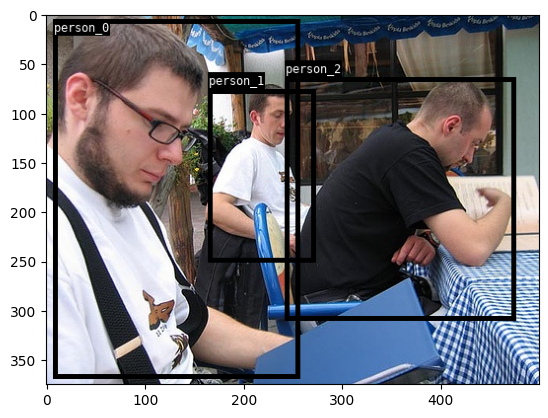

In [8]:
processor = AutoProcessor.from_pretrained("/data_ssd/huggingface_model_weights/microsoft/kosmos-2-patch14-224")
index = -2
data = save_json_data[index]
for key, velue in data.items():
    print(f"{key}: {velue}")
image_path = os.path.join(image_folder_root, data["image"])
sentence = data["conversations"][0]["value"] + data["conversations"][1]["value"]
caption, entities = processor.post_process_generation(sentence)
# assert len(entities) == 1, f"entities must be 1, but got {len(entities)}"
caption_list = []
bbox_list = []
for entity in entities:
    caption_list.extend([entity[0]]*len(entity[-1]))
    bbox_list.extend(entity[-1])
print(bbox_list)
visualize_bbox(image_path, bbox_list, caption_list, bbox_is_relative=True, with_id=True)

In [9]:
print(sentence)
print(processor.tokenizer.tokenize(sentence))
print(entities)

<image><grounding> Please carefully check the image and detect the following objects: [person].<phrase> person</phrase><object><patch_index_0000><patch_index_1008></object>|<phrase> person</phrase><object><patch_index_0202><patch_index_0689></object>|<phrase> person</phrase><object><patch_index_0175><patch_index_0862></object>
['<image>', '<grounding>', '▁Please', '▁carefully', '▁check', '▁the', '▁image', '▁and', '▁detect', '▁the', '▁following', '▁objects', ':', '▁[', 'person', ']', '.', '<phrase>', '▁person', '</phrase>', '<object>', '<patch_index_0000>', '<patch_index_1008>', '</object>', '▁|', '<phrase>', '▁person', '</phrase>', '<object>', '<patch_index_0202>', '<patch_index_0689>', '</object>', '▁|', '<phrase>', '▁person', '</phrase>', '<object>', '<patch_index_0175>', '<patch_index_0862>', '</object>']
[('person', (77, 83), [(0.015625, 0.015625, 0.515625, 0.984375)]), ('person', (85, 91), [(0.328125, 0.203125, 0.546875, 0.671875)]), ('person', (93, 99), [(0.484375, 0.171875, 0.95

In [2]:
processor = AutoProcessor.from_pretrained("/data_ssd/huggingface_model_weights/microsoft/kosmos-2-patch14-224")
processor.tokenizer.tokenize("</object>|<phrase>")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


['</object>', '▁|', '<phrase>']

# データセット作成に当たる検証

In [ ]:
cat_id2name = {
  0: "aeroplane",
  1: "bicycle",
  2: "bird",
  3: "boat",
  4: "bottle",
  5: "bus",
  6: "car",
  7: "cat",
  8: "chair",
  9: "cow",
  10: "diningtable",
  11: "dog",
  12: "horse",
  13: "motorbike",
  14: "person",
  15: "pottedplant",
  16: "sheep",
  17: "sofa",
  18: "train",
  19: "tvmonitor",
}



split = "train"
year = "2012"
#https://panda-clip.com/data-split-stratified/
#trainは2007のtrainと2012のtrainvalを使用
#valは2007のval
#testは2007のtest
anno_folder = f"/data_ssd/PASCAL-VOC/ultralytics/labels/{split}{year}"
image_folder_root = f"/data_ssd"

['2008_000008', '2008_000015', '2008_000019', '2008_000023', '2008_000028']
['12 0.522 0.5712669683257919 0.836 0.7533936651583711', '14 0.445 0.23642533936651586 0.262 0.27828054298642535']


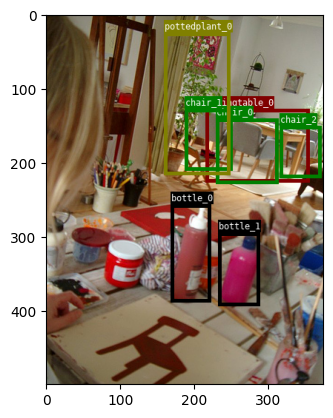

/data_ssd/PASCAL-VOC/ultralytics/images/train2012/2008_008330.jpg
[[0.448, 0.514, 0.592, 0.778], [0.6213333333333333, 0.5900000000000001, 0.768, 0.788], [0.576, 0.256, 0.9466666666666667, 0.45599999999999996], [0.6133333333333333, 0.28200000000000003, 0.8346666666666667, 0.45999999999999996], [0.49866666666666665, 0.256, 0.6693333333333333, 0.42200000000000004], [0.84, 0.302, 0.9893333333333333, 0.442], [0.424, 0.05199999999999999, 0.6613333333333333, 0.434]]
['bottle', 'bottle', 'diningtable', 'chair', 'chair', 'chair', 'pottedplant']


In [6]:
anno_id_list, anno_label_list, image_path_list = load_anno(anno_folder,image_folder_root)
bbox_list_list, bbox_name_list_list = anno_label_list_to_bbox_list(anno_label_list, cat_id2name)

print(anno_id_list[:5])
print(anno_label_list[0])
index = 2000
image_path = os.path.join(image_folder_root, image_path_list[index])
bbox_list = bbox_list_list[index]
bbox_name_list = bbox_name_list_list[index]

visualize_bbox(image_path, bbox_list, bbox_name_list, bbox_is_relative=True, with_id=True)
print(image_path)
print(bbox_list)
print(bbox_name_list)

In [7]:
anno_id_dict = get_one_class_multi_object_anno(anno_id_list, image_path_list, bbox_list_list, bbox_name_list_list)
item = anno_id_dict[anno_id_list[index]]
for key, value in item.items():
    if key == "image_path":
        print(f"{key}: {value}")
    else:
        print(f"{key}:")
        for bbox_name, bbox_list in value.items():
            print(f"  {bbox_name}: {bbox_list}")

max_instance_num: 27, min_instance_num: 1, average_instance_num: 2.380444288962743
image_path: PASCAL-VOC/ultralytics/images/train2012/2008_008330.jpg
instances:
  bottle: [[0.448, 0.514, 0.592, 0.778], [0.6213333333333333, 0.5900000000000001, 0.768, 0.788]]
  diningtable: [[0.576, 0.256, 0.9466666666666667, 0.45599999999999996]]
  chair: [[0.6133333333333333, 0.28200000000000003, 0.8346666666666667, 0.45999999999999996], [0.49866666666666665, 0.256, 0.6693333333333333, 0.42200000000000004], [0.84, 0.302, 0.9893333333333333, 0.442]]
  pottedplant: [[0.424, 0.05199999999999999, 0.6613333333333333, 0.434]]


In [8]:
save_json_data = []
for anno_id,bbox_list,bbox_name_list, image_path in tqdm(zip(anno_id_list, bbox_list_list, bbox_name_list_list, image_path_list), total=len(anno_id_list)):
    
    image_w_h_size = Image.open(os.path.join(image_folder_root,image_path)).size  # (width, height)
    object_name_with_loc_dict = make_object_name_with_loc_dict_per_image(bbox_name_list, bbox_list, image_w_h_size)
    
    for object_name, loc_list in object_name_with_loc_dict.items():
        id = f"{anno_id}_{object_name}"
        question, answer = make_question_and_answer(object_name, loc_list)
        conversation = make_conversation(id, image_path, question, answer, image_w_h_size, anno_id)
        save_json_data.append(conversation)

100%|██████████| 5717/5717 [00:06<00:00, 875.19it/s]


In [9]:
print(len(save_json_data))
print(object_name_with_loc_dict)
print(save_json_data[1])

8331
{'bird': ['<patch_index_0000><patch_index_0000>']}
{'id': '2008_000008_person', 'image': 'PASCAL-VOC/ultralytics/images/train2012/2008_000008.jpg', 'conversations': [{'from': 'human', 'value': '<image><grounding> <phrase> person</phrase>'}, {'from': 'gpt', 'value': '<object><patch_index_0000><patch_index_0000></object>'}], 'image_width_height': (500, 442), 'ann_id': '2008_000008'}


# 作成するデータセット
* 画像ごとに複数クラス、複数物体
* 物体ごとに分けて検出させる
* \<p\>\<p\>まで入力、後は出力